In [1]:
import pyTigerGraph as tg
import numpy as np
import pandas as pd

conn = tg.TigerGraphConnection("http://3.22.188.182", graphname="KDD_2022_NFT", username="tigergraph", password="tigergraph")

In [3]:
splitter = conn.gds.vertexSplitter(v_types=["Transaction"], train=0.8, test=0.2)

In [4]:
splitter.run()

Splitting vertices...
Vertex split finished successfully.


## Train on Category and Collection

In [5]:
train_loader = conn.gds.vertexLoader(
    attributes={"Transaction": ["usd_price", "categoryOneHot", "collectionOneHot"]},
    filter_by="train",
    batch_size=2048,
    shuffle=True
)

In [6]:
import torch

nn = torch.nn.Sequential(
    torch.nn.Linear(1075, 1000),
    torch.nn.ReLU(),
    torch.nn.Linear(1000, 1000),
    torch.nn.ReLU(),
    torch.nn.Linear(1000, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 1)
)

from torch.optim import Adam

opt = Adam(nn.parameters(), lr=0.01)
loss = torch.nn.SmoothL1Loss()
mae = torch.nn.L1Loss()

In [7]:
def r2_loss(output, target):
    target_mean = torch.mean(target)
    ss_tot = torch.sum((target - target_mean) ** 2)
    ss_res = torch.sum((target - output) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2

In [8]:
import numpy as np
def clean_onehots(x, length):
    arr = np.fromstring(x, sep=" ", dtype=np.float32)
    if len(arr) > length:
        arr = arr[:length]
    elif len(arr) < length:
        arr = np.zeros(length)
    return arr

In [9]:
for i in range(20):
    epoch_loss = 0
    epoch_mae = 0
    epoch_r2 = 0
    for batch in train_loader:
        catOH = torch.tensor(np.stack(batch["Transaction"]["categoryOneHot"].apply(lambda x: clean_onehots(x, 6)).values).astype(np.float32))
        collOH = torch.tensor(np.stack(batch["Transaction"]["collectionOneHot"].apply(lambda x: clean_onehots(x, 1069)).values).astype(np.float32))
        X = torch.tensor(np.concatenate([catOH, collOH], axis=1))
        y = torch.tensor(batch["Transaction"]["usd_price"].values.astype(np.float32))
        out = nn(X).flatten()
        loss_val = loss(out, y)
        opt.zero_grad()
        loss_val.backward()
        opt.step()
        epoch_loss += loss_val.item()
        epoch_mae += mae(out, y).item()
        epoch_r2 += r2_loss(out, y).item()
    print("Epoch:", i, "Loss:", epoch_loss/train_loader.num_batches, "MAE:", epoch_mae/train_loader.num_batches, "R2:", epoch_r2/train_loader.num_batches)

Epoch: 0 Loss: 114.83001152674358 MAE: 115.25283209482829 R2: 0.004087872803211212
Epoch: 1 Loss: 109.40959437688191 MAE: 109.82432428995769 R2: 0.07803699870904286
Epoch: 2 Loss: 106.4038610458374 MAE: 106.82251977920532 R2: 0.11306821306546529
Epoch: 3 Loss: 105.53812344868977 MAE: 105.95443773269653 R2: 0.13963950673739114
Epoch: 4 Loss: 103.28698857625325 MAE: 103.70203638076782 R2: 0.22842145462830862
Epoch: 5 Loss: 105.28106387456258 MAE: 105.69160302480061 R2: 0.15241743872563043
Epoch: 6 Loss: 102.62642097473145 MAE: 103.0471936861674 R2: 0.16644167403380075
Epoch: 7 Loss: 100.62688287099202 MAE: 101.05087025960286 R2: 0.3139521852135658
Epoch: 8 Loss: 101.39486614863078 MAE: 101.80862458546956 R2: 0.2782509848475456
Epoch: 9 Loss: 99.94942887624104 MAE: 100.37923177083333 R2: 0.0692429393529892
Epoch: 10 Loss: 99.9599781036377 MAE: 100.37276124954224 R2: 0.16715911527474722
Epoch: 11 Loss: 99.29011233647664 MAE: 99.70501375198364 R2: 0.301583006978035
Epoch: 12 Loss: 100.42353

In [10]:
test_loader = conn.gds.vertexLoader(
    attributes={"Transaction": ["usd_price", "categoryOneHot", "collectionOneHot"]},
    filter_by="test",
    batch_size=2048
)

In [11]:
mae_sum = 0
r2_sum = 0
for batch in test_loader:
    catOH = torch.tensor(np.stack(batch["Transaction"]["categoryOneHot"].apply(lambda x: clean_onehots(x, 6)).values).astype(np.float32))
    collOH = torch.tensor(np.stack(batch["Transaction"]["collectionOneHot"].apply(lambda x: clean_onehots(x, 1069)).values).astype(np.float32))
    X = torch.tensor(np.concatenate([catOH, collOH], axis=1))
    y = torch.tensor(batch["Transaction"]["usd_price"].values.astype(np.float32))
    with torch.no_grad():
        out = nn(X).flatten()
        mae_sum += mae(out, y).item()
        r2_sum += r2_loss(out, y).item()
print("MAE:", mae_sum/test_loader.num_batches, "R2:", r2_sum/test_loader.num_batches)

MAE: 143.1186180114746 R2: 0.20849900444348654


## Add Graph Features

In [12]:
%%writefile ./seller_pagerank.gsql

CREATE QUERY seller_pagerank(BOOL print_accum = FALSE, STRING result_attr = "") {
    transactions = {Transaction.*};
    SumAccum<DOUBLE> @seller_pr;
    MaxAccum<DOUBLE> @@max_seller_pr;


    res = SELECT t FROM transactions:t -(NFT_SOLD_BY)-> NFT_User:u 
          ACCUM
            t.@seller_pr += u.pagerank,
            @@max_seller_pr += u.pagerank
          POST-ACCUM
            IF result_attr != "" THEN
                t.setAttr(result_attr, t.@seller_pr/@@max_seller_pr)
            END;
    IF print_accum THEN
      PRINT res[res.@seller_pr];
    END;
}

Overwriting ./seller_pagerank.gsql


In [13]:
featurizer = conn.gds.featurizer()

In [14]:
featurizer.installAlgorithm("seller_pagerank", query_path="./seller_pagerank.gsql")

'seller_pagerank'

In [15]:
params = {"result_attr": "seller_pr"}

try:
    featurizer.runAlgorithm("seller_pagerank", params, feat_name="seller_pr", feat_type="DOUBLE", custom_query=True, schema_name=["Transaction"])
except ConnectionError:
    featurizer.runAlgorithm("seller_pagerank", params)

In [16]:
%%writefile ./buyer_pagerank.gsql

CREATE QUERY buyer_pagerank(BOOL print_accum = FALSE, STRING result_attr = "") {
    transactions = {Transaction.*};
    SumAccum<DOUBLE> @buyer_pr;
    MaxAccum<DOUBLE> @@max_buyer_pr;


    res = SELECT t FROM transactions:t -(NFT_BOUGHT_BY)-> NFT_User:u 
          ACCUM
            t.@buyer_pr += u.pagerank,
            @@max_buyer_pr += u.pagerank
          POST-ACCUM
            IF result_attr != "" THEN
                t.setAttr(result_attr, t.@buyer_pr/@@max_buyer_pr)
            END;
    IF print_accum THEN
      PRINT res[res.@buyer_pr];
    END;
}

Overwriting ./buyer_pagerank.gsql


In [17]:
featurizer.installAlgorithm("buyer_pagerank", query_path="./buyer_pagerank.gsql")

'buyer_pagerank'

In [18]:
params = {"result_attr": "buyer_pr"}

try:
    featurizer.runAlgorithm("buyer_pagerank", params, feat_name="buyer_pr", feat_type="DOUBLE", custom_query=True, schema_name=["Transaction"])
except ConnectionError:
    featurizer.runAlgorithm("buyer_pagerank", params)

In [19]:
%%writefile ./kcore_size.gsql

CREATE QUERY kcore_size(BOOL print_accum = FALSE, STRING result_attr = "") FOR GRAPH KDD_2022_NFT { 
  MapAccum<INT, SumAccum<FLOAT>> @@kcore_size;
  MaxAccum<FLOAT> @@max_kcore_size;

  
  nftuser = {NFT_User.*};
  
  res = SELECT t FROM nftuser:t POST-ACCUM @@kcore_size += (t.k_core -> 1);
  
  IF print_accum THEN
    PRINT @@kcore_size;
  END;

  FOREACH (key, value) IN @@kcore_size DO
    @@max_kcore_size += value;
  END;
  
  IF result_attr != "" THEN
    res = SELECT t FROM nftuser:t POST-ACCUM t.setAttr(result_attr, @@kcore_size.get(t.k_core)/@@max_kcore_size);
  END;
}

Overwriting ./kcore_size.gsql


In [20]:
featurizer.installAlgorithm("kcore_size", query_path="./kcore_size.gsql")

'kcore_size'

In [21]:
params = {"result_attr": "kcore_size"}
try:
    featurizer.runAlgorithm("kcore_size", params, feat_name="kcore_size", feat_type="DOUBLE", custom_query=True, schema_name=["NFT_User"])
except ConnectionError:
    featurizer.runAlgorithm("kcore_size", params, custom_query=True)

In [22]:
%%writefile ./seller_kcore_size.gsql

CREATE QUERY seller_kcore_size(BOOL print_accum = FALSE, STRING result_attr = "") {
    transactions = {Transaction.*};
    SumAccum<DOUBLE> @seller_k_size;


    res = SELECT t FROM transactions:t -(NFT_SOLD_BY)-> NFT_User:u 
          ACCUM
            t.@seller_k_size += u.kcore_size
          POST-ACCUM
            IF result_attr != "" THEN
                t.setAttr(result_attr, t.@seller_k_size)
            END;
    IF print_accum THEN
      PRINT res[res.@seller_k_size];
    END;
}

Overwriting ./seller_kcore_size.gsql


In [23]:
featurizer.installAlgorithm("seller_kcore_size", query_path="./seller_kcore_size.gsql")

'seller_kcore_size'

In [24]:
params = {"result_attr": "seller_k_size"}

try:
    featurizer.runAlgorithm("seller_kcore_size", params, feat_name="seller_k_size", feat_type="DOUBLE", custom_query=True, schema_name=["Transaction"])
except ConnectionError:
    featurizer.runAlgorithm("seller_kcore_size", params)

In [25]:
%%writefile ./buyer_kcore_size.gsql

CREATE QUERY buyer_kcore_size(BOOL print_accum = FALSE, STRING result_attr = "") {
    transactions = {Transaction.*};
    SumAccum<DOUBLE> @buyer_k_size;


    res = SELECT t FROM transactions:t -(NFT_BOUGHT_BY)-> NFT_User:u 
          ACCUM
            t.@buyer_k_size += u.kcore_size
          POST-ACCUM
            IF result_attr != "" THEN
                t.setAttr(result_attr, t.@buyer_k_size)
            END;
    IF print_accum THEN
      PRINT res[res.@buyer_k_size];
    END;
}

Overwriting ./buyer_kcore_size.gsql


In [26]:
featurizer.installAlgorithm("buyer_kcore_size", query_path="./buyer_kcore_size.gsql")

'buyer_kcore_size'

In [27]:
params = {"result_attr": "buyer_k_size"}

try:
    featurizer.runAlgorithm("buyer_kcore_size", params, feat_name="buyer_k_size", feat_type="DOUBLE", custom_query=True, schema_name=["Transaction"])
except ConnectionError:
    featurizer.runAlgorithm("buyer_kcore_size", params)

In [28]:
tmp = conn.getSchema(force=True)

In [29]:
train_loader = conn.gds.vertexLoader(
    attributes={"Transaction": ["buyer_k_size", "seller_k_size", "usd_price", "seller_pr", "buyer_pr", "categoryOneHot", "collectionOneHot"]},
    filter_by="train",
    batch_size=2048,
    shuffle=True
)

In [30]:
import torch

nn = torch.nn.Sequential(
    torch.nn.Linear(1079, 1000),
    torch.nn.ReLU(),
    torch.nn.Linear(1000, 1000),
    torch.nn.ReLU(),
    torch.nn.Linear(1000, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 1)
)

from torch.optim import Adam

opt = Adam(nn.parameters(), lr=0.01)
loss = torch.nn.SmoothL1Loss()
mae = torch.nn.L1Loss()

In [31]:
for i in range(20):
    epoch_loss = 0
    epoch_mae = 0
    epoch_r2 = 0
    for batch in train_loader:
        catOH = torch.tensor(np.stack(batch["Transaction"]["categoryOneHot"].apply(lambda x: clean_onehots(x, 6)).values).astype(np.float32))
        collOH = torch.tensor(np.stack(batch["Transaction"]["collectionOneHot"].apply(lambda x: clean_onehots(x, 1069)).values).astype(np.float32))
        X = torch.tensor(np.concatenate([batch["Transaction"][["seller_k_size", "buyer_k_size", "seller_pr", "buyer_pr"]].values.astype(np.float32), catOH, collOH], axis=1))
        y = torch.tensor(batch["Transaction"]["usd_price"].values.astype(np.float32))
        out = nn(X).flatten()
        loss_val = loss(out, y)
        opt.zero_grad()
        loss_val.backward()
        opt.step()
        epoch_loss += loss_val.item()
        epoch_mae += mae(out, y).item()
        epoch_r2 += r2_loss(out, y).item()
    print("Epoch:", i, "Loss:", epoch_loss/train_loader.num_batches, "MAE:", epoch_mae/train_loader.num_batches, "R2:", epoch_r2/train_loader.num_batches)

Epoch: 0 Loss: 115.05246829986572 MAE: 115.47657616933186 R2: 0.002668869992097219
Epoch: 1 Loss: 109.56136719385783 MAE: 109.97741635640462 R2: 0.06366720050573349
Epoch: 2 Loss: 107.2056695620219 MAE: 107.61985556284587 R2: 0.10972668478886287
Epoch: 3 Loss: 104.79964590072632 MAE: 105.21757872899373 R2: 0.18685349076986313
Epoch: 4 Loss: 102.03520329793294 MAE: 102.4475146929423 R2: 0.2678019255399704
Epoch: 5 Loss: 100.94859822591145 MAE: 101.37051788965861 R2: 0.2039502834280332
Epoch: 6 Loss: 102.29503870010376 MAE: 102.7117280960083 R2: 0.1455250804622968
Epoch: 7 Loss: 100.29191652933757 MAE: 100.70326646169026 R2: 0.15900569160779318
Epoch: 8 Loss: 98.61704158782959 MAE: 99.03449408213298 R2: 0.22544477631648382
Epoch: 9 Loss: 98.26459376017253 MAE: 98.67620801925659 R2: 0.07242680837710698
Epoch: 10 Loss: 98.13151009877522 MAE: 98.55422560373943 R2: 0.21438431491454443
Epoch: 11 Loss: 100.19113858540852 MAE: 100.61390415827434 R2: 0.2286224663257599
Epoch: 12 Loss: 97.4877607

In [32]:
test_loader = conn.gds.vertexLoader(
    attributes={"Transaction": ["seller_k_size", "buyer_k_size", "usd_price", "seller_pr", "buyer_pr", "categoryOneHot", "collectionOneHot"]},
    filter_by="test",
    batch_size=2048
)

In [33]:
mae_sum = 0
r2_sum = 0
for batch in test_loader:
    catOH = torch.tensor(np.stack(batch["Transaction"]["categoryOneHot"].apply(lambda x: clean_onehots(x, 6)).values).astype(np.float32))
    collOH = torch.tensor(np.stack(batch["Transaction"]["collectionOneHot"].apply(lambda x: clean_onehots(x, 1069)).values).astype(np.float32))
    X = torch.tensor(np.concatenate([batch["Transaction"][["seller_k_size", "buyer_k_size", "seller_pr", "buyer_pr"]].values.astype(np.float32), catOH, collOH], axis=1))
    y = torch.tensor(batch["Transaction"]["usd_price"].values.astype(np.float32))
    with torch.no_grad():
        out = nn(X).flatten()
        mae_sum += mae(out, y).item()
        r2_sum += r2_loss(out, y).item()
print("MAE:", mae_sum/test_loader.num_batches, "R2:", r2_sum/test_loader.num_batches)

MAE: 136.02754974365234 R2: 0.24481361111005148


In [34]:
from captum.attr import GradientShap

gs = GradientShap(nn)

/opt/anaconda3/envs/kdd2022/lib/python3.9/site-packages/captum/attr/_utils/visualization.py:15: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display


In [35]:
train_batch = next(iter(train_loader))

catOH = torch.tensor(np.stack(train_batch["Transaction"]["categoryOneHot"].apply(lambda x: clean_onehots(x, 6)).values).astype(np.float32))
collOH = torch.tensor(np.stack(train_batch["Transaction"]["collectionOneHot"].apply(lambda x: clean_onehots(x, 1069)).values).astype(np.float32))
train_x = torch.tensor(np.concatenate([train_batch["Transaction"][["seller_k_size", "buyer_k_size", "seller_pr", "buyer_pr"]].values.astype(np.float32), catOH, collOH], axis=1))
test_batch = next(iter(test_loader))

catOH = torch.tensor(np.stack(test_batch["Transaction"]["categoryOneHot"].apply(lambda x: clean_onehots(x, 6)).values).astype(np.float32))
collOH = torch.tensor(np.stack(test_batch["Transaction"]["collectionOneHot"].apply(lambda x: clean_onehots(x, 1069)).values).astype(np.float32))
test_x = torch.tensor(np.concatenate([test_batch["Transaction"][["seller_k_size", "buyer_k_size", "seller_pr", "buyer_pr"]].values.astype(np.float32), catOH, collOH], axis=1))

In [36]:
attribution = gs.attribute(test_x, train_x)

[Text(0, 0, 'Seller_k_size'),
 Text(1, 0, 'Buyer_k_size'),
 Text(2, 0, 'Seller_pr'),
 Text(3, 0, 'Buyer_pr')]

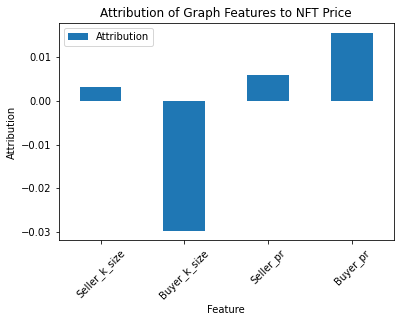

In [37]:
ig_nt_attr_test_sum = attribution.detach().numpy().sum(0)
ig_nt_attr_test_norm_sum = ig_nt_attr_test_sum / np.linalg.norm(ig_nt_attr_test_sum, ord=1)

attributions = pd.DataFrame({"Feature": ["Seller_k_size", "Buyer_k_size", "Seller_pr", "Buyer_pr"], "Attribution": ig_nt_attr_test_norm_sum[:4]})

plt = attributions.plot(kind="bar", xlabel="Feature", ylabel="Attribution", title="Attribution of Graph Features to NFT Price")
plt.set_xticklabels(attributions.Feature, rotation=45)

In [38]:
# Just PR: MAE: 111.11622746785481 R2: 0.17277953028678894